In [63]:
import pandas as pd
import numpy as np 
import re
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from patsy import dmatrices

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import ProbPlot
plt.style.use('seaborn') # pretty matplotlib plots
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

In [65]:
abbrev = pd.read_csv("abbrev.csv")
abbrev.head()

,Unnamed: 0,household_size,empl_agriculture,empl_professional,empl_social,empl_services,empl_manufacturing,empl_retail,empl_transp_utilities,prc_fam_poverty,...,deaths_april1,deaths,cases_march24,cases_april1,cases_april23,ten_plus,order,density,death_prc,uninsured
0,0,2.56,1.079230,11.181199,19.409400,8.323099,22.213539,10.247107,5.654795,9.9,...,0,0.000001,0,19,50,26,20,205.559775,8.397081e-12,1.185668
1,1,3.15,14.810805,7.410151,21.601702,8.941190,7.127118,9.305904,4.424056,15.6,...,0,1.000000,0,4,35,11,36,108.941861,6.606503e-06,9.905791
2,2,3.31,15.989974,10.084580,19.673111,10.873224,6.512608,8.971354,3.888164,10.5,...,1,4.000000,14,42,154,33,36,132.778760,9.182863e-06,3.714698
3,3,2.37,1.339175,16.368947,20.669588,11.533536,3.509718,10.598809,6.790248,5.1,...,0,1.000000,2,26,36,26,36,104.091797,1.003049e-05,1.227732
4,4,2.59,1.066778,9.394248,25.461959,11.484731,4.417867,12.854456,5.007969,9.5,...,1,3.000000,2,7,28,20,36,47.687662,1.666296e-05,0.826483


In [66]:
abbrev = abbrev.drop('Unnamed: 0', axis=1)
abbrev.columns.values

array(['household_size', 'empl_agriculture', 'empl_professional',
       'empl_social', 'empl_services', 'empl_manufacturing',
       'empl_retail', 'empl_transp_utilities', 'prc_fam_poverty',
       'avg_income', 'prc_public_transp', 'population', 'pop_65_plus',
       'county', 'state', 'FIPS', 'area', 'prc_obese', 'incarcerated',
       'domestic_passengers', 'intl_passengers', 'deaths_march24',
       'deaths_april1', 'deaths', 'cases_march24', 'cases_april1',
       'cases_april23', 'ten_plus', 'order', 'density', 'death_prc',
       'uninsured'], dtype=object)

In [67]:
predictors = ['household_size', 'empl_agriculture', 'empl_professional','empl_social', 'empl_services', 
              'empl_manufacturing', 'empl_retail', 'empl_transp_utilities', 'prc_fam_poverty',
              'avg_income', 'prc_public_transp', 'population', 'pop_65_plus', 'uninsured', 'area', 
              'incarcerated', 'domestic_passengers', 'intl_passengers', 'prc_obese', 'ten_plus', 
              'order', 'density', 'cases_march24']
# omitting april case data, since it's pretty much perfectly correlated with deaths

predictors_noCaseData = predictors.copy()
predictors_noCaseData.remove('cases_march24')

transform = ["population", "density", "intl_passengers", "domestic_passengers", "area", 
            "cases_march24", "incarcerated", "empl_agriculture", "prc_public_transp"]

for field in transform:
    abbrev.loc[abbrev[field] == 0, field] = 0.0000001
    abbrev["log_"+field] = np.log1p(abbrev[field])
    
log_predictors = predictors.copy()
for field in transform:
    log_predictors.remove(field)
    log_predictors.append("log_"+field)
    
log_predictors_noCaseData = log_predictors.copy()
log_predictors_noCaseData.remove('log_cases_march24')

In [68]:
indp_vars = [predictors_noCaseData, predictors, 
             log_predictors_noCaseData, log_predictors]
labels = ["no case data", "with case data", 
          "with transformed predictors, no case data", 
          "with transformed predictors, with case data"]

In [69]:
abbrev["log_deaths"] = np.log1p(abbrev["deaths"])

In [70]:
# apply standard scaling to predictors

original = abbrev.copy()
all_predictors = set()
for x in indp_vars:
    all_predictors = all_predictors.union(x)
    
all_predictors = list(all_predictors)
scaler = StandardScaler()
scaler.fit(abbrev[all_predictors])
abbrev[all_predictors] = scaler.transform(abbrev[all_predictors])

abbrev[all_predictors].describe()

,empl_retail,empl_transp_utilities,empl_social,log_prc_public_transp,log_cases_march24,prc_obese,order,incarcerated,log_domestic_passengers,domestic_passengers,...,prc_fam_poverty,empl_agriculture,log_incarcerated,log_intl_passengers,avg_income,empl_services,pop_65_plus,density,empl_professional,intl_passengers
count,8.270000e+02,8.270000e+02,8.270000e+02,8.270000e+02,8.270000e+02,8.270000e+02,8.270000e+02,8.270000e+02,8.270000e+02,8.270000e+02,...,8.270000e+02,8.270000e+02,8.270000e+02,8.270000e+02,8.270000e+02,8.270000e+02,8.270000e+02,8.270000e+02,8.270000e+02,8.270000e+02
mean,-2.178494e-16,1.753015e-16,-9.090203e-17,-2.013706e-17,1.389457e-16,2.213734e-16,1.986856e-17,4.081949e-17,4.430152e-18,-9.591951e-17,...,1.346162e-16,9.491266e-17,5.040976e-16,1.052497e-16,-3.040695e-17,-3.557547e-17,1.733465e-16,1.612643e-17,4.188508e-17,3.503848e-16
std,1.000605e+00,1.000605e+00,1.000605e+00,1.000605e+00,1.000605e+00,1.000605e+00,1.000605e+00,1.000605e+00,1.000605e+00,1.000605e+00,...,1.000605e+00,1.000605e+00,1.000605e+00,1.000605e+00,1.000605e+00,1.000605e+00,1.000605e+00,1.000605e+00,1.000605e+00,1.000605e+00
min,-5.711034e+00,-2.776217e+00,-5.030994e+00,-1.043367e+00,-1.323476e+00,-3.177501e+00,-3.186548e+00,-6.130193e-01,-1.141028e+00,-4.539130e-01,...,-1.820517e+00,-7.114566e-01,-3.802689e+00,-5.099840e-01,-2.214456e+00,-3.473266e+00,-2.110942e+00,-2.498650e-01,-2.809658e+00,-2.566046e-01
25%,-6.170632e-01,-6.868665e-01,-6.320650e-01,-6.770501e-01,-6.191891e-01,-6.437849e-01,-4.636448e-01,-4.260728e-01,-1.141028e+00,-4.539130e-01,...,-7.373239e-01,-5.121651e-01,-3.039255e-01,-5.099840e-01,-6.593107e-01,-6.117986e-01,-6.369323e-01,-2.096455e-01,-6.728445e-01,-2.566046e-01
50%,-4.956333e-02,-1.505714e-01,-1.444403e-01,-3.024958e-01,-1.748333e-01,8.147965e-02,-9.233984e-02,-2.728744e-01,5.819784e-01,-4.217655e-01,...,-1.486322e-01,-3.259710e-01,8.582683e-02,-5.099840e-01,-1.795283e-01,-1.329819e-01,-9.638015e-02,-1.708331e-01,-1.435173e-01,-2.566046e-01
75%,5.508205e-01,5.516479e-01,5.215196e-01,3.942034e-01,5.641148e-01,6.937159e-01,7.740383e-01,4.728821e-02,8.545602e-01,-2.177694e-01,...,5.577978e-01,1.320938e-01,5.184642e-01,-5.099840e-01,4.667065e-01,4.316509e-01,4.452745e-01,-8.304943e-02,5.074356e-01,-2.566046e-01
max,4.843879e+00,6.203258e+00,4.696597e+00,4.712229e+00,4.145173e+00,3.133242e+00,1.516648e+00,1.481073e+01,1.269958e+00,4.477269e+00,...,4.796378e+00,8.773816e+00,2.576654e+00,2.454217e+00,5.451130e+00,8.014222e+00,9.470146e+00,2.082053e+01,5.563573e+00,8.051965e+00


## Functions for Modelling, Analyzing

In [71]:
def get_predictor_combo(pred_set):
    pred_formula = ""
    ind_vars = list()
    for col in pred_set:
        if col != "deaths" and col != "log_deaths":
            ind_vars.append(col)
    return " + ".join(ind_vars)

def get_linear_formula(pred_set, dep_var_name):
    pred_formula = get_predictor_combo(pred_set)
    form = dep_var_name + " ~ " + pred_formula
    return re.sub(" +", " ", form)

def get_form_w_2ndO_interactions(pred_set, dep_var_name):
    main_effects = get_predictor_combo(pred_set)
    interactions = set()
    for x in range(len(pred_set)):
        for y in range(x + 1, len(pred_set)):
            a = pred_set[x] + ":" + pred_set[y]
            b = pred_set[y] + ":" + pred_set[x]
            if a not in interactions and b not in interactions:
                interactions.add(a)
    pred_formula = main_effects if len(interactions) == 0 else main_effects + " + " + " + ".join(list(interactions))
    form = dep_var_name + " ~ " + pred_formula
    return re.sub(" +", " ", form)

def get_var_names_from_formula(formula):
    indp = re.sub("^.+ ~ ", "", formula)
    return indp.split(" + ")

In [72]:
def print_result(model, form):
    print(model.summary())
    
    print("\n{} variables with significant coefficients\n".format(len(model.pvalues[model.pvalues < 0.05])))
          
    names = get_var_names_from_formula(form)
    names.insert(0, "Intercept")
    print("{:50} {:>6} {:>8}".format("VARIABLE", "P-VAL", "COEFF"))
    for a,b,c in zip(model.pvalues, names, model.params):
        if abs(a) < 0.05:
            print("{:50} {:>6.3f} {:>8.3f}".format(b, a, c))

def print_results(models, forms, num):
    print_result(models[num], forms[num])

In [104]:
#  from https://robert-alvarez.github.io/2018-06-04-diagnostic_plots/
def graph(formula, x_range, label=None):
    """
    Helper function for plotting cook's distance lines
    """
    x = x_range
    y = formula(x)
    plt.plot(x, y, label=label, lw=1, ls='--', color='red')


def diagnostic_plots(X, y, model_fit=None):
    """
    Function to reproduce the 4 base plots of an OLS model in R.
    ---
    Inputs:
    X: A numpy array or pandas dataframe of the features to use in building the linear regression model
    y: A numpy array or pandas series/dataframe of the target variable of the linear regression model
    model_fit [optional]: a statsmodel.api.OLS model after regressing y on X. If not provided, will be
                        generated from X, y                    
    """

    if not model_fit:  
        model_fit = sm.OLS(y, sm.add_constant(X)).fit()

    # create dataframe from X, y for easier plot handling
    dataframe = pd.concat([X, y], axis=1)
    # model values
    model_fitted_y = model_fit.fittedvalues
    # model residuals
    model_residuals = model_fit.resid
    # normalized residuals
    model_norm_residuals = model_fit.get_influence().resid_studentized_internal
    # absolute squared normalized residuals
    model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
    # absolute residuals
    model_abs_resid = np.abs(model_residuals)
    # leverage, from statsmodels internals
    model_leverage = model_fit.get_influence().hat_matrix_diag
    # cook's distance, from statsmodels internals
    model_cooks = model_fit.get_influence().cooks_distance[0]
    
    plot_lm_1 = plt.figure()
    plot_lm_1.axes[0] = sns.residplot(model_fitted_y, dataframe.columns[-1], data=dataframe,
                            lowess=True,
                            scatter_kws={'alpha': 0.5},
                            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    plot_lm_1.axes[0].set_title('Residuals vs Fitted')
    plot_lm_1.axes[0].set_xlabel('Fitted values')
    plot_lm_1.axes[0].set_ylabel('Residuals');
    
    # annotations
    abs_resid = model_abs_resid.sort_values(ascending=False)
    abs_resid_top_3 = abs_resid[:3]
    for i in abs_resid_top_3.index:
        plot_lm_1.axes[0].annotate(i,
                                 xy=(model_fitted_y[i],
                                     model_residuals[i]));

    QQ = ProbPlot(model_norm_residuals)
    plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
    plot_lm_2.axes[0].set_title('Normal Q-Q')
    plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
    plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
    # annotations
    abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
    abs_norm_resid_top_3 = abs_norm_resid[:3]
    for r, i in enumerate(abs_norm_resid_top_3):
        plot_lm_2.axes[0].annotate(i,
                                 xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                     model_norm_residuals[i]));

    plot_lm_3 = plt.figure()
    plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5);
    sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt,
              scatter=False,
              ci=False,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
    plot_lm_3.axes[0].set_title('Scale-Location')
    plot_lm_3.axes[0].set_xlabel('Fitted values')
    plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

    # annotations
    abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
    abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
    for i in abs_norm_resid_top_3:
        plot_lm_3.axes[0].annotate(i,
                                 xy=(model_fitted_y[i],
                                     model_norm_residuals_abs_sqrt[i]));


    plot_lm_4 = plt.figure();
    plt.scatter(model_leverage, model_norm_residuals, alpha=0.5);
    sns.regplot(model_leverage, model_norm_residuals,
              scatter=False,
              ci=False,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
    plot_lm_4.axes[0].set_xlim(0, max(model_leverage)+0.01)
    plot_lm_4.axes[0].set_ylim(-10, 30)
    plot_lm_4.axes[0].set_title('Residuals vs Leverage')
    plot_lm_4.axes[0].set_xlabel('Leverage')
    plot_lm_4.axes[0].set_ylabel('Standardized Residuals');

    # annotations
    leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]
    for i in leverage_top_3:
        plot_lm_4.axes[0].annotate(i,
                                 xy=(model_leverage[i],
                                     model_norm_residuals[i]));

    p = len(model_fit.params) # number of model parameters
    graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x),
        np.linspace(0.001, max(model_leverage), 50),
        'Cook\'s distance') # 0.5 line
    graph(lambda x: np.sqrt((1 * p * (1 - x)) / x),
        np.linspace(0.001, max(model_leverage), 50)) # 1 line
    plot_lm_4.legend(loc='upper right');

## Linear Model

In [74]:
formulas = list()
for var_set in indp_vars:
    formulas.append(get_linear_formula(var_set, "deaths"))

lrms = list()
for formula in formulas:
    lrm = sm.formula.ols(formula = formula, data=abbrev).fit()
    lrms.append(lrm)

no case data
                            OLS Regression Results                            
Dep. Variable:                 deaths   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     121.1
Date:                Sat, 25 Apr 2020   Prob (F-statistic):          1.48e-237
Time:                        13:40:14   Log-Likelihood:                -5039.3
No. Observations:                 827   AIC:                         1.012e+04
Df Residuals:                     804   BIC:                         1.023e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept        

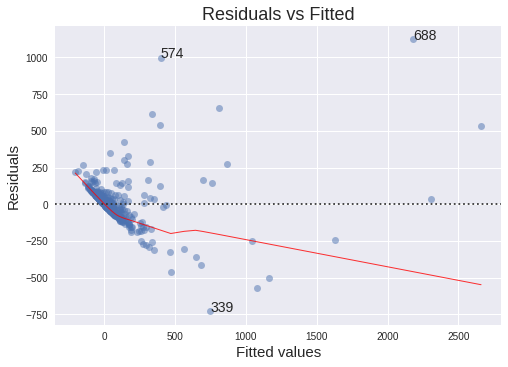

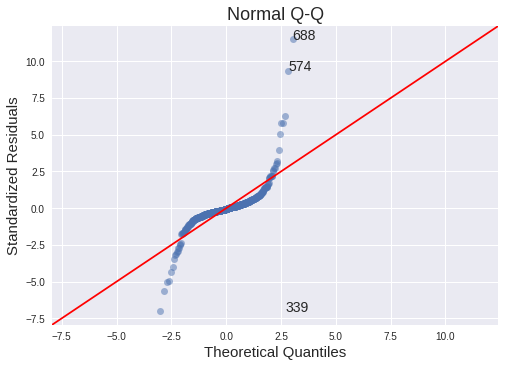

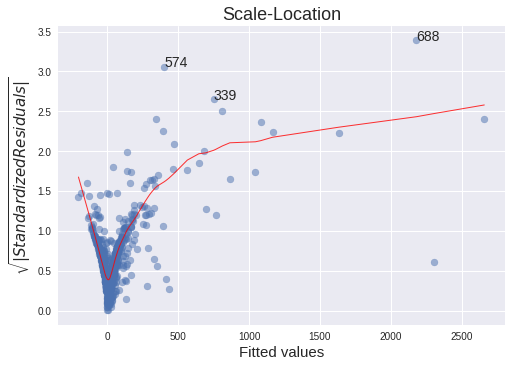

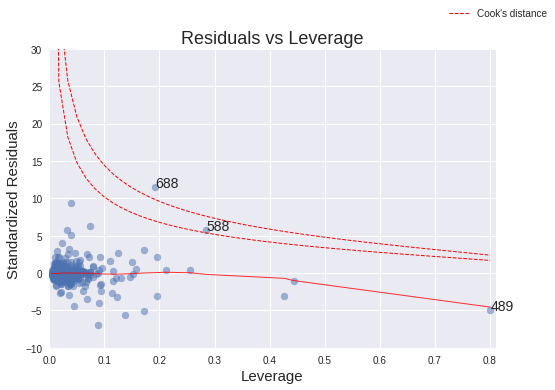

In [75]:
print(labels[0])
print_results(lrms, formulas, 0)
diagnostic_plots(abbrev[indp_vars[0]], abbrev["deaths"], lrms[0])
# might want to enable scroll for the cell...

with case data
                            OLS Regression Results                            
Dep. Variable:                 deaths   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     286.8
Date:                Sat, 25 Apr 2020   Prob (F-statistic):               0.00
Time:                        13:25:36   Log-Likelihood:                -4725.5
No. Observations:                 827   AIC:                             9499.
Df Residuals:                     803   BIC:                             9612.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept      

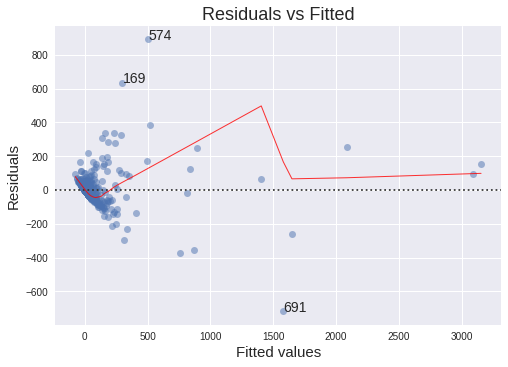

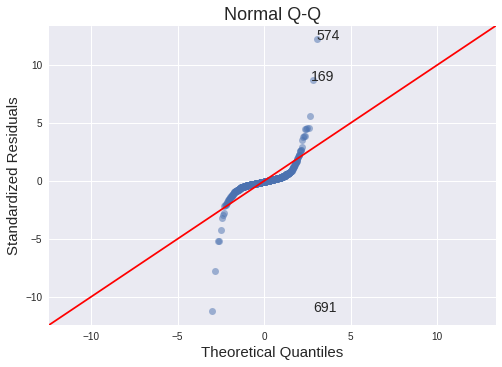

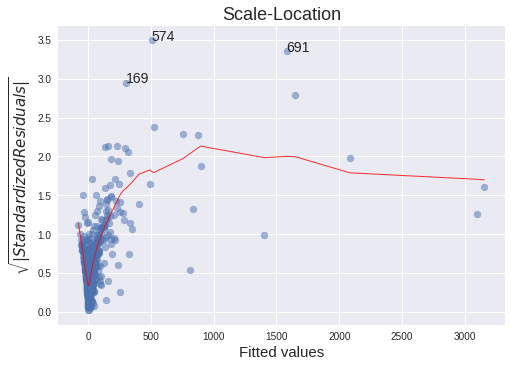

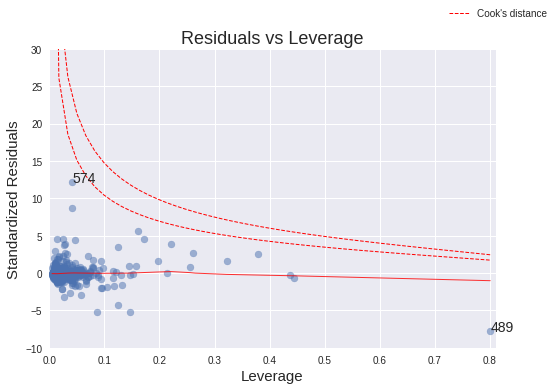

In [49]:
print(labels[1])
print_results(lrms, formulas, 1)
diagnostic_plots(abbrev[indp_vars[1]], abbrev["deaths"], lrms[1])

with transformed predictors, no case data
                            OLS Regression Results                            
Dep. Variable:                 deaths   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     26.21
Date:                Sat, 25 Apr 2020   Prob (F-statistic):           2.36e-79
Time:                        13:26:07   Log-Likelihood:                -5420.2
No. Observations:                 827   AIC:                         1.089e+04
Df Residuals:                     804   BIC:                         1.100e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

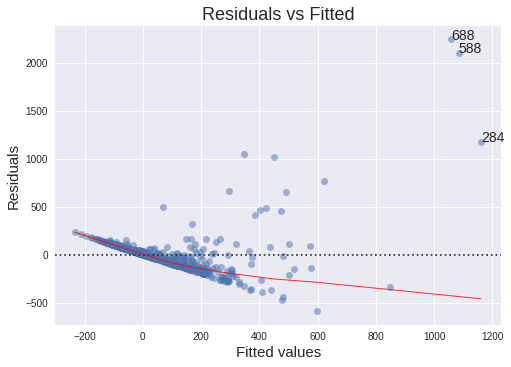

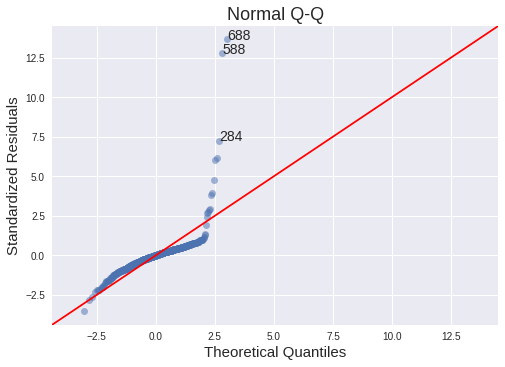

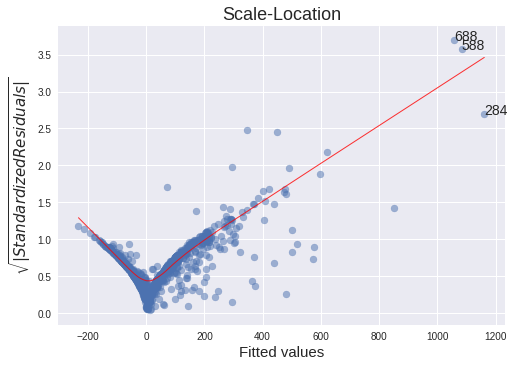

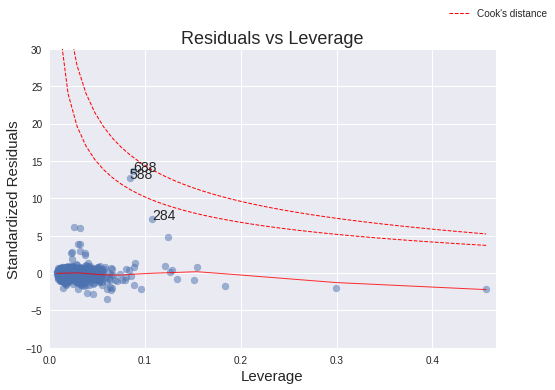

In [50]:
print(labels[2])
print_results(lrms, formulas, 2)
diagnostic_plots(abbrev[indp_vars[2]], abbrev["deaths"], lrms[2])

with transformed predictors, with case data
                            OLS Regression Results                            
Dep. Variable:                 deaths   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     33.67
Date:                Sat, 25 Apr 2020   Prob (F-statistic):          2.35e-101
Time:                        13:26:24   Log-Likelihood:                -5364.6
No. Observations:                 827   AIC:                         1.078e+04
Df Residuals:                     803   BIC:                         1.089e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

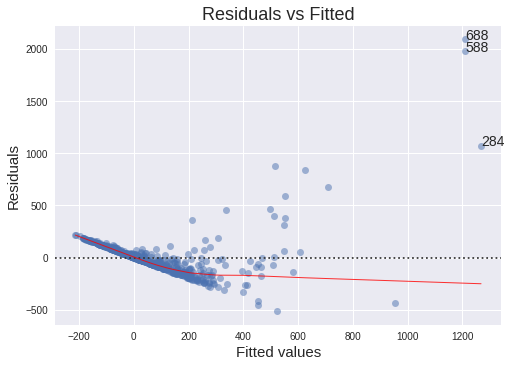

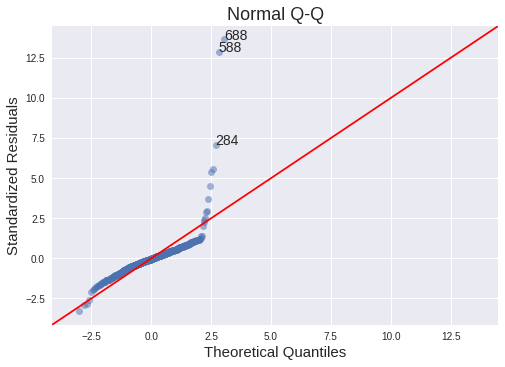

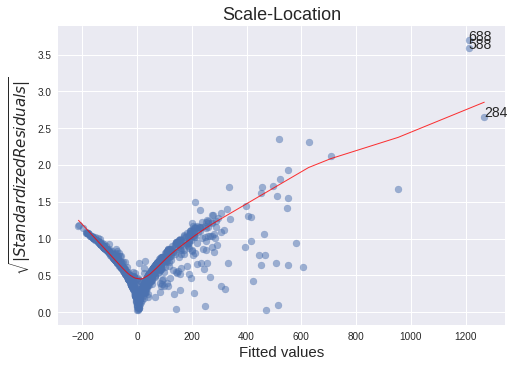

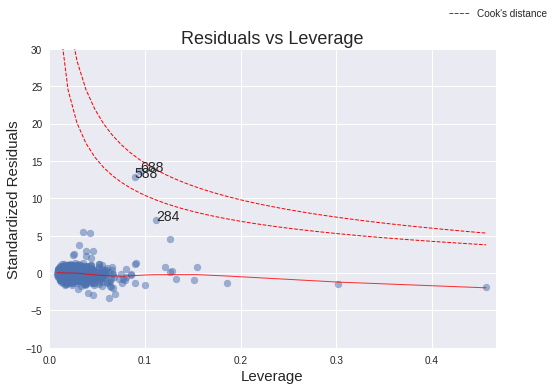

In [51]:
print(labels[3])
print_results(lrms, formulas, 3)
diagnostic_plots(abbrev[indp_vars[3]], abbrev["deaths"], lrms[3])

## Poisson-Family GLM

Using R via r-magic since found difficult to get same functionality plotting from statsmodels without lots of time-consuming internet searches

In [110]:
def diagnostic_plot_poisson(model):
    plot_lm_1 = plt.figure()
    plot_lm_1.axes[0] = sns.residplot(x=model.fittedvalues, y=model.resid_pearson,
                                      lowess=True,
                                scatter_kws={'alpha': 0.5},
                                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    plot_lm_1.axes[0].set_title('Residuals vs Fitted')
    plot_lm_1.axes[0].set_xlabel('Fitted values')
    plot_lm_1.axes[0].set_ylabel('Residuals');

In [102]:
pglms = list()
for var_set in indp_vars:
    X = np.column_stack( (np.ones((abbrev[var_set].shape[0], 1)), abbrev[var_set]) )
    y = abbrev["deaths"]
    pglm = sm.GLM(y, X, family=stats.families.Poisson()).fit()
    pglms.append(pglm)

no case data
                 Generalized Linear Model Regression Results                  
Dep. Variable:                 deaths   No. Observations:                  827
Model:                            GLM   Df Residuals:                      804
Model Family:                 Poisson   Df Model:                           22
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16704.
Date:                Sat, 25 Apr 2020   Deviance:                       30533.
Time:                        14:47:37   Pearson chi2:                 4.18e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3710      0.013    177

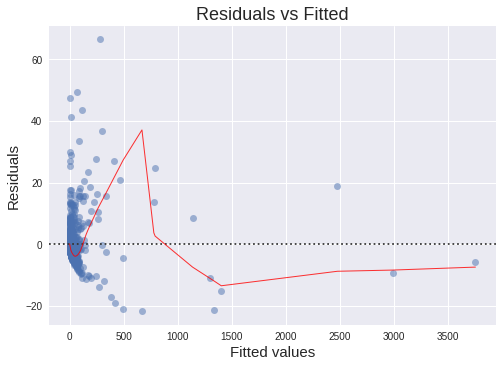

In [111]:
print(labels[0])
print_results(pglms, formulas, 0)
diagnostic_plot_poisson(pglms[0])

In [ ]:
pglms[0].get_influence.

In [126]:
import rpy2.robjects as robjects

In [112]:
%load_ext rpy2.ipython

In [128]:
formulas[0]

'deaths ~ household_size + empl_agriculture + empl_professional + empl_social + empl_services + empl_manufacturing + empl_retail + empl_transp_utilities + prc_fam_poverty + avg_income + prc_public_transp + population + pop_65_plus + uninsured + area + incarcerated + domestic_passengers + intl_passengers + prc_obese + ten_plus + order + density'

In [129]:
%%R -i abbrev

mod = glm(formula = deaths ~ household_size + empl_agriculture + empl_professional + empl_social + 
          empl_services + empl_manufacturing + empl_retail + empl_transp_utilities + 
          prc_fam_poverty + avg_income + prc_public_transp + population + pop_65_plus + uninsured +
          area + incarcerated + domestic_passengers + intl_passengers + prc_obese + ten_plus + 
          order + density, family = poisson(link = "log"), data = abbrev)

In [135]:
%%R 

summary(mod)


Call:
glm(formula = deaths ~ household_size + empl_agriculture + empl_professional + 
    empl_social + empl_services + empl_manufacturing + empl_retail + 
    empl_transp_utilities + prc_fam_poverty + avg_income + prc_public_transp + 
    population + pop_65_plus + uninsured + area + incarcerated + 
    domestic_passengers + intl_passengers + prc_obese + ten_plus + 
    order + density, family = poisson(link = "log"), data = abbrev)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-28.541   -3.748   -1.640    0.711   47.267  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)            2.371038   0.013350 177.603  < 2e-16 ***
household_size         0.026324   0.008487   3.102  0.00192 ** 
empl_agriculture      -0.843034   0.022373 -37.680  < 2e-16 ***
empl_professional     -0.287384   0.013335 -21.551  < 2e-16 ***
empl_social           -0.112237   0.010950 -10.250  < 2e-16 ***
empl_services         -0.332737   0.010351 -32.1

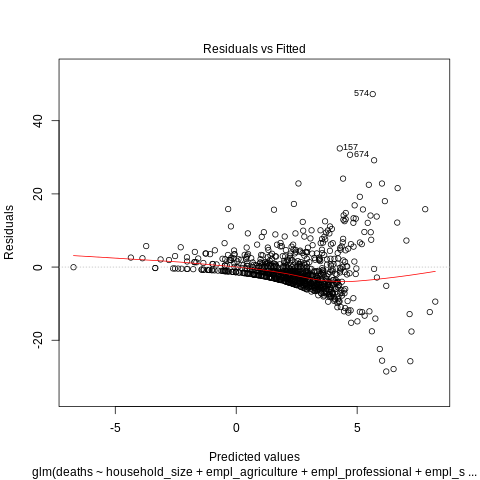

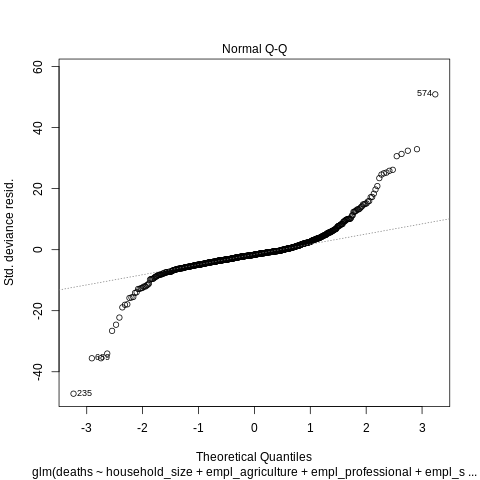

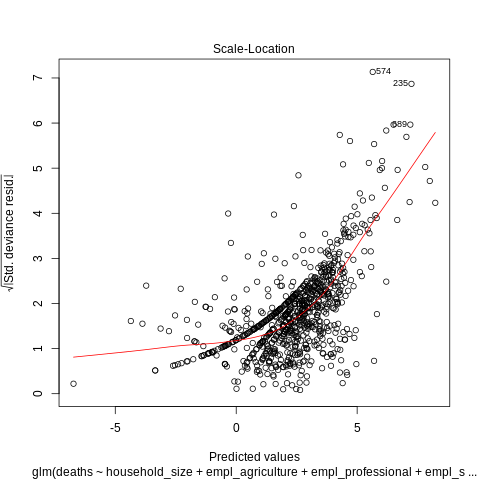

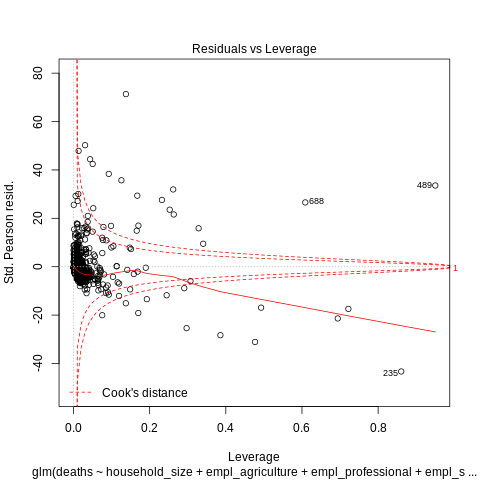

In [136]:
%%R

plot(mod)